<a href="https://colab.research.google.com/github/WhiteFox-Lugh/e-ty-rating-simulation/blob/main/simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import scipy.stats
import random
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
import seaborn as sns
import copy
import math
from bisect import bisect_left, bisect_right
from matplotlib.pyplot import show
from scipy.stats import norm

In [ ]:
# 定数
# 平均的な人のレーティング
average_user_rating = 1200
# Elo Rating の K 因子
k = 30
# 勝率の比が 1:10 になるレーティング差
q = 400.0
# 勝率の比が 1:10 になる score の差
p = 100.0
# 対戦回数
match_num = 50
# レーティングの近い前後何人とマッチするか
match_user_range = 250
# 事前に計算したスコア分布
# 正規分布を仮定し、平均と標準偏差を算出
score_mu = 259.21321
score_scale = 103.110675
# シード値の固定
random.seed(743)

In [ ]:
# 分布に従いユーザを生成する
# ただし、3シグマ範囲を超えるユーザはほぼ生成されないので、
# 手動で生成する分も含む
user_score = np.array([i for i in range(1, 850, 5)])
user_score = np.append(user_score, norm.rvs(loc=score_mu,scale=score_scale,size=5500))
# スコアが負の人を排除
user_score = user_score[user_score > 0]
# あとで見やすくするためソート
user_score = np.sort(user_score)
# レーティング初期化
user_rating = np.zeros(len(user_score))
user_num = len(user_score)

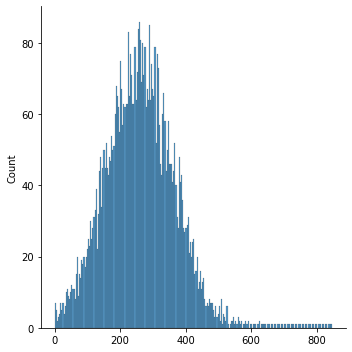

In [ ]:
sns.displot(user_score, bins=250)

In [ ]:
# レーティング差から期待される成績を算出する
def elo_logistic_function(rating_i, rating_j):
  return 1.0 / (1.0 + np.power(10, -(rating_i - rating_j) / q))

# スコア差から勝率を算出し、乱数で勝敗を決定
def score_function(score_i, score_j):
  prob = 1.0 / (1.0 + np.power(10, -(score_i - score_j) / p))
  r = random.random()
  return 1 if r <= prob else 0

# レーティングの更新
def update_rating(user_i, user_j):
  # 対戦前のレーティングの抽出
  old_rating_i = user_rating[user_i]
  old_rating_j = user_rating[user_j]
  # エタイでのスコアを抽出
  score_i = user_score[user_i]
  score_j = user_score[user_j]
  # 勝敗を決定
  s_ij = score_function(score_i, score_j)
  s_ji = 1 - s_ij
  # 現在のレーティングにおいてどれくらいの勝率になるかを計算
  mu_ij = elo_logistic_function(old_rating_i, old_rating_j)
  mu_ji = elo_logistic_function(old_rating_j, old_rating_i)
  # レーティングを更新
  new_rating_i = old_rating_i + k * (s_ij - mu_ij)
  new_rating_j = old_rating_j + k * (s_ji - mu_ji)
  user_rating[user_i] = new_rating_i
  user_rating[user_j] = new_rating_j
  return

In [ ]:
# シミュレーションする関数
def simulate():
  # シミュレーションの繰り返し
  for l in range(match_num):
    # プレイヤー i と j を戦わせる
    # i == j のときは自分同士での対戦になるのでスキップ
    for i in range(user_num):
      for j in range(max(0, i - match_user_range), min(user_num, i + match_user_range + 1)):
        if i == j:
          continue
        update_rating(i, j)
  return

In [ ]:
# ここを実行すると実際にシミュレーションが動きます
simulate()

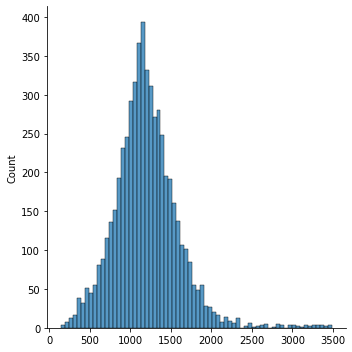

In [ ]:
# 最終的なレーティングの値を算出し、分布をプロットします
rating_list = user_rating + average_user_rating
sns.displot(rating_list)

In [ ]:
# 以下、レーティングとスコアの対応関係を出すだけのプログラム
# レーティング最小値と最大値を算出し整数に
min_rating = int(np.min(rating_list)) - 1
max_rating = int(np.max(rating_list)) + 1
min_rating, max_rating

(142, 3491)

In [ ]:
# 各レーティングについてスコアを出す
rating_score_dict = {}
# (rating, score) のタプルのリストをつくる
tuple_list = list(map(lambda a, b: (a, b), rating_list, user_score))
tuple_list.sort(key=lambda x:x[0])
rating_list = list(map(lambda x: x[0], tuple_list))
score_list = list(map(lambda x: x[1], tuple_list))

In [ ]:
for rating in range(min_rating, max_rating, 1):
  l = bisect_left(rating_list, rating)
  if l < user_num:
    score = user_score[l]
    rating_score_dict[rating] = int(math.ceil(score))

In [ ]:
# レーティング境界ラインを出してみる
# 境界は CF を参照
rating_border_list = [1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2700, 3000]
score_border_list = list(map(lambda x: rating_score_dict[x], rating_border_list))
score_border_list

[203, 270, 330, 382, 428, 476, 526, 586, 656, 726]

In [ ]:
# パーセンタイルとスコア
percentile_list = [(np.percentile(rating_list, i / 10.0), np.percentile(score_list, i / 10.0)) for i in range(0, 1000)]
output_percentile = [100, 200, 300, 400, 500, 600, 700, 750, 800, 850, 900, 950, 970, 975, 980, 985, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999]
score_percentile_border_list = list(map(lambda x: (percentile_list[int(x)][0], percentile_list[(int(x))][1]), output_percentile))
score_percentile_border_list

[(741.7503225484841, 129.08134365715665),
 (902.8876960222094, 173.5612877699664),
 (1011.3829459265571, 205.5305769894951),
 (1100.0730938407355, 233.88153793656653),
 (1171.7811994136018, 260.1240155458112),
 (1256.5274160315034, 286.86716149830994),
 (1354.000184004393, 314.0781114311335),
 (1404.4943921095423, 331.1097693754725),
 (1476.297990590468, 348.0908505989484),
 (1554.5505588550398, 368.84106007056744),
 (1659.6120133166771, 394.70954484174746),
 (1835.9216024178213, 434.9084862525517),
 (1964.9190896540663, 467.09075379755143),
 (2016.6317725169552, 480.1390301044112),
 (2082.962591251314, 501.0240942451345),
 (2206.8708868187496, 525.7171684341522),
 (2392.1646158818994, 585.0704077896878),
 (2500.4133012686384, 601.8399999999983),
 (2598.4881015959804, 625.9457211308473),
 (2692.9462124768615, 648.3199999999997),
 (2827.112713647791, 676.560000000005),
 (2938.483623065957, 704.8000000000011),
 (3019.7945556315053, 733.0400000000018),
 (3180.7342952261233, 761.2799999999